---
title: Debugging the issue of low variance in Enformer CAGE prediction
description: We checked whether our genes have peaks at the TSS and then compared the variation of CAGE predictions from the two different methods of centering intervals.
author: Sabrina Mi
date: 8/9/23

---

### Setup

In [35]:
import h5py
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import kipoiseq 
from kipoiseq import Interval
import pyfaidx
import matplotlib.pyplot as plt
import seaborn as sns
import random
predictions_dir = "/home/s1mi/enformer_rat_pipeline/predictions_folder/personalized_Br_genes/predictions_2023-08-08/enformer_predictions"


In [2]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/home/s1mi/enformer_rat_data/rn7_genome.fasta'

In [3]:

annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/rn7.gene.txt", sep="\t", index_col='geneId')

/tmp/ipykernel_14448/515731113.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/rn7.gene.txt", sep="\t", index_col='geneId')


In [39]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism

  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.


# @title `variant_centered_sequences`

class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}
    #import pd.Interval as Interval
    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)



# @title `plot_tracks`

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()


  def plot_track(title, y, interval, height=1.5):
    fig, ax = plt.subplots(figsize=(20, height))
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
    ax.set_xlabel(str(interval))
    plt.tight_layout()


In [5]:
model = Enformer(model_path)

fasta_extractor = FastaStringExtractor(fasta_file)

In [50]:
def compute_tss_bin(output_window_coords_resized, tss_position, output_length=114688, bin_length=128, rc=False):
    '''
    Computes the bin index of the enformer output bin containing the TSS
    Inputs:
    output_window_coords_resized: Kipoiseq interval for the output window of Enformer, should already be resized to the model output window size
    tss_position: absolute location of TSS
    output_length: Length of output window in base pairs
    bin_size: Length of output bins in base pairs
    Outputs:
    tss_bin: Index of bin containing TSS
    '''
    try:
        relative_position = int(tss_position) - int(output_window_coords_resized.start)
    except:
    # print(tss_position)
    # print(output_window_coords_resized.start)
        sys.exit()

    if relative_position < 0 or relative_position > output_length:
        # print(tss_position, "appears to be out of bounds for output window: ",output_window_coords_resized)
        return None 
    else:
        center = relative_position // bin_length

        
        if rc:
            number_of_bins = int(output_length/bin_length)
            new_center = number_of_bins - 1 - center
            # print(new_center)
            return [new_center-1,new_center,new_center+1]
        else:
            # print(center)
            return [center-1,center,center+1]

## Check reference genome for peaks

We selected 7 genes based of prediction performance in elastic training, and ran Enformer on 340 individuals centered at the TSS for each gene. Since we did not see any association between predicted and observed expression, we run Enformer with the reference genome to consider their relative expression levels compared in a transcriptome-wide context.

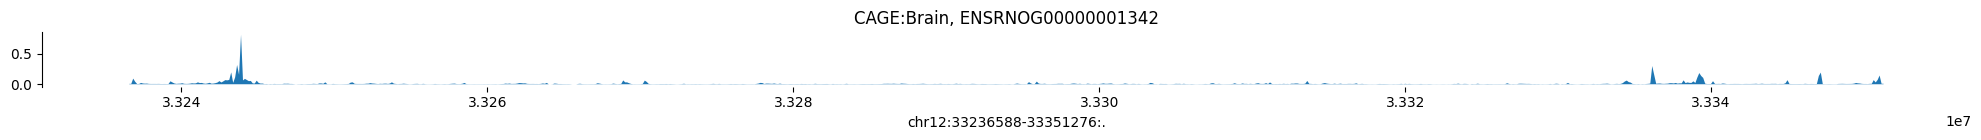

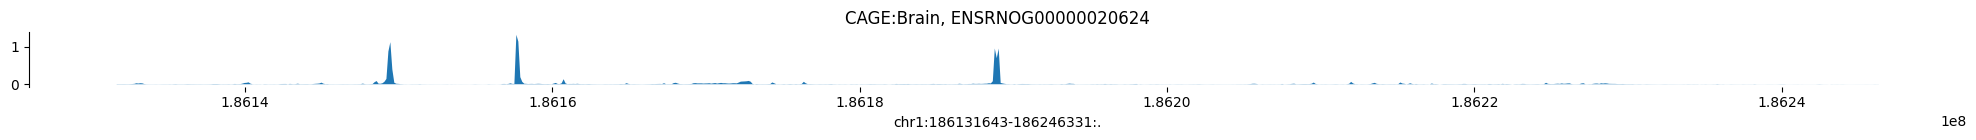

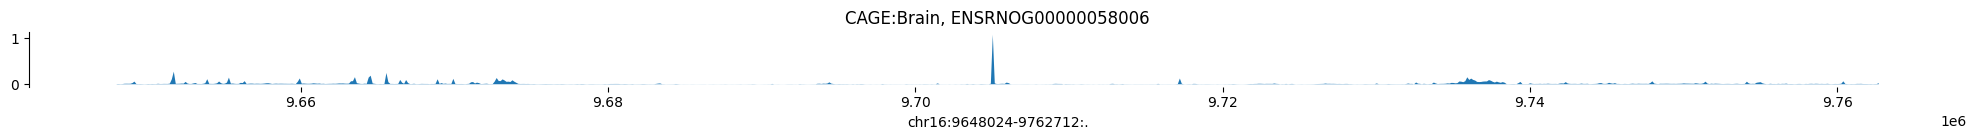

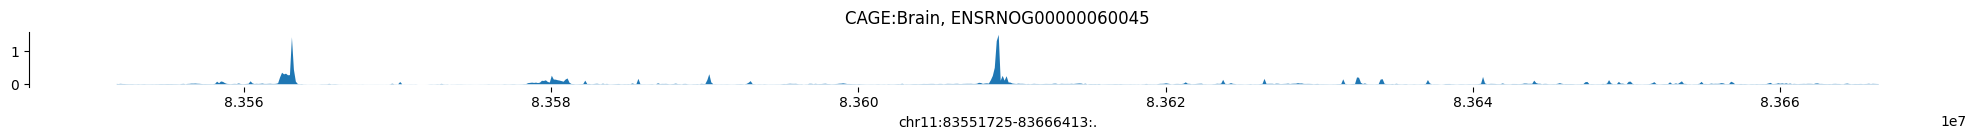

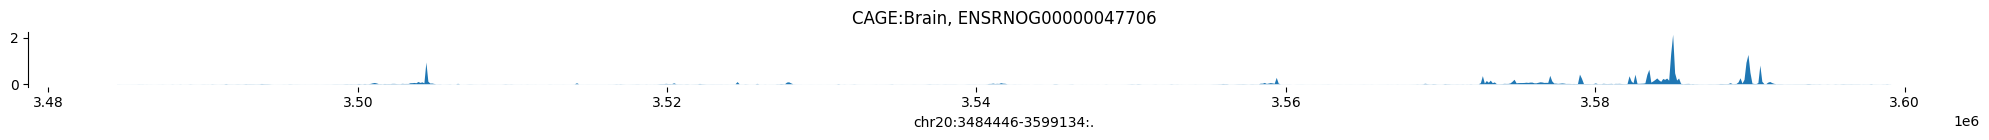

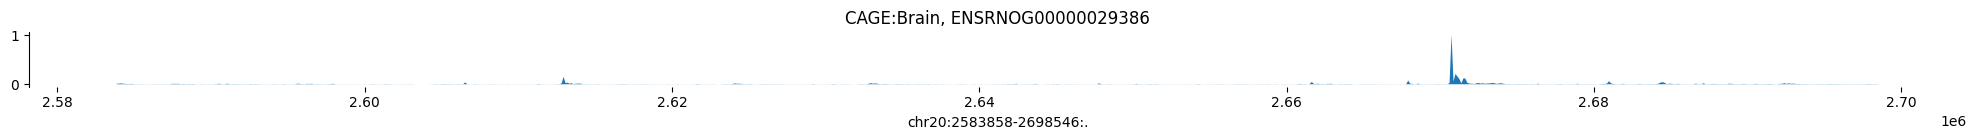

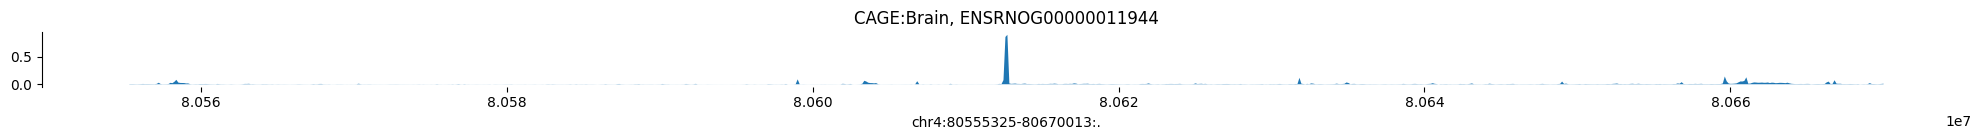

In [46]:
with open("gene_list.txt") as f:
    gene_list = f.read().splitlines()

CAGE_predictions = {}

for gene in gene_list:
    gene_annot = annot_df.loc[gene]
    tss = kipoiseq.Interval(f"chr{gene_annot['chromosome']}", gene_annot['tss'], gene_annot['tss'])
    sequence_one_hot = one_hot_encode(fasta_extractor.extract(tss.resize(SEQUENCE_LENGTH)))
    prediction = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]
    CAGE_predictions[gene] = prediction[:,4980]
    plot_track('CAGE:Brain, ' + gene, np.log10(1 + CAGE_predictions[gene]), tss.resize(114688))
    
    

Several genes have peaks at the center of the interval, where we fixed the TSS. This indicates that Enformer is correctly identifying TSS, even if some genes don't show peaks at the TSS.

## Variance across Interval


We have two genes with CAGE:Brain peaks at the TSS, now we take a closer look at the predictions generated from the pipeline compared to the original usage notebook.

In [56]:
genes_of_interest = ['ENSRNOG00000020624', 'ENSRNOG00000058006']
individuals = os.listdir(predictions_dir)


old_predictions_dir = "/home/s1mi/enformer_rat_pipeline/predictions_folder/personalized_enformer_minimal_some_regions/predictions_2023-07-26/enformer_predictions"
predictions = {}


for gene in genes_of_interest:
    print(gene)
    predictions[gene] = pd.DataFrame(index = individuals)
    gene_annot = annot_df.loc[gene]
    interval_obj = Interval("chr" + str(gene_annot['chromosome']), gene_annot['start'], gene_annot['end'])
    tss_bins = compute_tss_bin(interval_obj.resize(114688), gene_annot['tss'])
    interval = f"chr{gene_annot['chromosome']}_{gene_annot['start']}_{gene_annot['end']}"
    for individual in individuals:
        predictions_file = h5py.File(f"{old_predictions_dir}/{individual}/haplotype1/{interval}_predictions.h5", "r")
        matrix = predictions_file[interval][()]
        pred_expr = np.average(matrix[tss_bins, 4980])
        predictions[gene].loc[individual, 0] = pred_expr


ENSRNOG00000020624
ENSRNOG00000058006


In [63]:
for gene in genes_of_interest:
    gene_annot = annot_df.loc[gene]
    start = gene_annot['tss'] - 57344
    end = gene_annot['tss'] + 57344
    for individual in individuals:
        interval = f"chr{gene_annot['chromosome']}_{start}_{end}"
        predictions_file = h5py.File(f"{predictions_dir}/{individual}/haplotype1/{interval}_predictions.h5", "r")
        matrix = predictions_file[interval][()]
        pred_expr = np.average(matrix[447:449, 4980])
        predictions[gene].loc[individual,1] = pred_expr


In [64]:
for gene in genes_of_interest:
    print(gene)
    print("Old Range:", predictions[gene][0].unique())
    print("New Range:", predictions[gene][1].unique())

ENSRNOG00000020624
Old Range: [4.09390497 4.09556913 4.09526396]
New Range: [6.03277731 6.03283596]
ENSRNOG00000058006
Old Range: [0.0266992  0.0266884  0.02666909]
New Range: [0.01251906 0.01252023]


## Conclusions

For both genes, centering enformer predictions at the TSS, rather than the start and end of genes, reduces variation in CAGE predictions. It is unclear to me why shifting the center increases CAGE values around the TSS for one gene but decreases them for the other gene. I think I should focus on picking genes with (1) more variation in observed expression, (2) CAGE peaks at the TSS, and (3) high R2 in elasticnet models, and continue centering our intervals around the start and end of our genes.